# Detecting Fraudulent Activities

**Background**:   
I am given a dataset from a company running an e-commerce website that sells hand-made clothes. It contains information on the first transactions of many different users as well as whether a given user went on to perform fraudulent activity or not.

**Goals**:   
* Determine the country of all users based on their IP addresses
* Build a model that predicts the probability that the first transaction of a new user is fraudulent. Explain how different assumptions about the cost of false positives vs false negatives impact the model.
* Explain to your boss (who is not technical at all!!) how the model is making predictions and why they should trust it. Do this from a user perspective, i.e., describe what kind of users are more likely to be classified at risk, what are their characteristics, why is this reasonable? Your boss is afraid you might turn away valid paying customers by accident with such a tool.
* If your model is now live and making predictions in real time, describe how it should be used from a product perspective, i.e., what kind of user experiences would you recommend be built based on the model output?

**Results**:
* The most important features in spotting fraud were determined to be:
    * The speed at which they moved through the entire sales funnel (from sign-up to purchase)
    * Whether or not multiple user id's were being generated from a single device or ip address
* It turns out that not all ip addresses in the dataset can be tracked to a country of origin. It's not clear whether the list of countries and ip address bounds is incomplete, some ip addresses were faked, or an error occurred in recording the ip address. Regardless, country of origin does not play a significant role in determining fraudsters so it doesn't really matter.
* I built two models:
    * Isolation forest: a supervised alogorithm based on analyzing how many splits on features are necessary to isolate a given sample.
    * One Class Support Vector Machine: an unsupervised algorithm based on learning a decision boundary surrounding non-anomalous data and then trying to identify anomalies by determining their distance from this boundary.     
* It is important to both correctly identify fraudulent behaviour when it arises (we want a high precision) and not flag normal users as fraudulent ones, thereby alienating our customer base (we want a high recall). To optimize for both precision and recall simultaneously, I decided to optimize for F1 score, the harmonic mean of precision and recall, rather than accuracy. Using this method of optimization, I found that **the isolation forest performs better than the one class SVM**. Although the SVM has comparable precision, recall, and F1 scores to the isolation forest, it is not as flexible as the isolation forest in dealing with non-gaussian, multi-modal data.


**Non-technical explanation**:   

Although the two models developed approach the problem differently, both are trying to ascertain what "normal" user behaviour is in terms of how much a "normal" user spends, how fast they move through the sales funnel, their age, etc. These characteristics are all represented by numbers and these numbers will tend to be somewhat similar values for "normal" users. For fraudulent users, some of these numbers may be quite different and it is this departure from "normal" behaviour that these models are trying to discover. The models leverage these numbers and advanced statistical techniques to also characterize, with numbers, just how different a fraudulent user behaviour is from that of a "normal" user. Using these techniques, I discovered that the users who are most likely to be classified as a risk by these models are those who:
1. have multiple user id's associated with a single device or ip address 
2. move from sign-up to purchase in extremely short periods of time. 
    
For point 1., a user may forget their username/password and therefore sign up again, generating a new user id for the same device or ip address. However, in this case it is highly likely that only one user id would be used at a time. If multiple user ids are in use simultaneously, this may signal that someone has set up a botnet to interact with the website. Moreover, many of the fraudulent activities in the dataset were associated with devices or ip addresses making use of up to 10+ user ids. This is certainly not something a "normal" user would ever do. 
    
For point 2., a typical time period that would potentially result in a red flag from one of these algorithms is 1-2 seconds. A normal user takes a few minutes to simply navigate the website even if they've already made the decision to purchase. This time is extended if the user has to make any decisions about their purchase. If the entire sales funnel is being traversed in literally 1-2 seconds, this is again a likely sign that it is actually a bot of some kind interacting with the website.
    
**Recommendations**:   
I recommend implementing the isolation forest model into production. I also have two specific recommendations for the user experience team and one for the security team.
1. Make sure to require the full name and email address from a user in order to sign up. When a user forgets their username/password, give them an easy path to follow to **reset** their password and require their full name and email address in order to do it. That way, the user's original user id can be found in the database and deleted before giving them a new user id. This minimizes the chances of a normal user having multiple user id's and reduces the chances of mistaking them for a fraudster.
2. After a user signs up, immediately present them with potential offers/discounts if possible. This could be advertised as a simple thank you for signing up but, for normal users, it will increase their chances of moving to purchase while also giving them something to consider and thereby slowing them down a little bit, making it harder to confuse them with a bot which would likely ignore all offers for discounts.
3. Finally, I also strongly recommend enhancing security during the first three weeks of the year as there seems to be a spike in fraudulent activity during that time.

First, I'll list all imports

In [2]:
# Analysis imports
import numpy as np
import pandas as pd
from scipy import special
from random import sample

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Modeling imports
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import f1_score

# Miscellaneous imports
import itertools
from datetime import timedelta
from IPython.display import display

# Miscellaneous settings
pd.options.display.max_seq_items = 2000

## Read in and clean the data

In [3]:
# Read in fraud data
fraud_df = pd.read_csv("Fraud_Data/Fraud_Data.csv", header=0)

# Read in ISP data
ISP_df = pd.read_csv("Fraud_Data/IpAddress_to_Country.csv", header=0)

### Fraud data
First, check format of columns in fraud datset.

In [4]:
for col in fraud_df.columns:
    print "{}: {}".format(col, fraud_df[col].dtype)

user_id: int64
signup_time: object
purchase_time: object
purchase_value: int64
device_id: object
source: object
browser: object
sex: object
age: int64
ip_address: float64
class: int64


Check for null values

In [5]:
# Check for nulls
print "Check for null values"
for col in fraud_df.columns:
    print "# of null values in {}: {}".format(col, fraud_df[col].isnull().sum())

Check for null values
# of null values in user_id: 0
# of null values in signup_time: 0
# of null values in purchase_time: 0
# of null values in purchase_value: 0
# of null values in device_id: 0
# of null values in source: 0
# of null values in browser: 0
# of null values in sex: 0
# of null values in age: 0
# of null values in ip_address: 0
# of null values in class: 0


Finally, look at some descriptive stats

In [6]:
fraud_df.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


### ISP data
First, check format of columns in ISP dataset.

In [7]:
for col in ISP_df.columns:
    print "{}: {}".format(col, ISP_df[col].dtype)

lower_bound_ip_address: float64
upper_bound_ip_address: int64
country: object


It's not clear whether the lower bound for the ip address is actually a float, i.e., has non-zero decimals, or is just an integer with a zero decimal.

In [8]:
ip_floats = ISP_df.lower_bound_ip_address.apply(lambda x: not x.is_integer()).sum()
print "Number of non-zero decimal ip address lower bounds: {}".format(ip_floats)

Number of non-zero decimal ip address lower bounds: 0


It's just a bunch of integers with zero decimals so I'll convert the entire series to int64.

In [9]:
ISP_df.lower_bound_ip_address = ISP_df.lower_bound_ip_address.astype(int)

Just to be sure, I'll also check for null values

In [10]:
# Check for nulls
print "Check for null values"
for col in ISP_df.columns:
    print "# of null values in {}: {}".format(col, ISP_df[col].isnull().sum())

Check for null values
# of null values in lower_bound_ip_address: 0
# of null values in upper_bound_ip_address: 0
# of null values in country: 0


Finally, I'll just take a look at some descriptive stats.

In [11]:
ISP_df.describe()

,lower_bound_ip_address,upper_bound_ip_address
count,1.388460e+05,1.388460e+05
mean,2.724532e+09,2.724557e+09
std,8.975215e+08,8.974979e+08
min,1.677722e+07,1.677747e+07
25%,1.919930e+09,1.920008e+09
50%,3.230887e+09,3.230888e+09
75%,3.350465e+09,3.350466e+09
max,3.758096e+09,3.758096e+09


The min of the lower and upper bounds is separated by 25 which seems reasonable to me. However, the max of both the lower and upper bounds are equal which definitely seems strange. Is there a single instance where the lower and upper bounds are equal?

In [12]:
display(ISP_df[ ISP_df.lower_bound_ip_address == ISP_df.lower_bound_ip_address.max() ])
display(ISP_df[ ISP_df.upper_bound_ip_address == ISP_df.upper_bound_ip_address.max() ])

,lower_bound_ip_address,upper_bound_ip_address,country
138845,3758096128,3758096383,Australia


,lower_bound_ip_address,upper_bound_ip_address,country
138845,3758096128,3758096383,Australia


Ok, it was just a false alarm. The trailing decimals not shown in the describe output differ from one another so everything seems to be fine.

## Missing IP addresses

Comparing the descriptive stats of each dataset, I noticed that the min (max) IP address in the fraud dataset is lower (higher) than the min (max) IP address in the ISP dataset. This will definitely create problems when creating a map. It's also possible that some IP addresses in the fraud dataset aren't in the ISP dataset even if they do lie within the min and max of the ISP dataset. It would be helpful to know the counts associated with each of these errors and also to know how many IP addresses do have a unique country assigned to them.

In [13]:
def isp_counts(isp):
    country = ISP_df[(ISP_df.lower_bound_ip_address <= isp) & (ISP_df.upper_bound_ip_address >= isp)].country
    if country.shape[0] == 1:
        return "Unique"
    elif country.shape[0] > 1:
        return "Multiple countries"
    elif country.shape[0] == 0:
        if isp > ISP_df.upper_bound_ip_address.max():
            return "Too big"
        elif isp < ISP_df.lower_bound_ip_address.min():
            return "Too small"
        else:
            return "Missing from the middle"
        
ip_counts = fraud_df.ip_address.apply(isp_counts)
ip_counts.value_counts()

Unique                     129146
Too big                     19383
Missing from the middle      1949
Too small                     634
Name: ip_address, dtype: int64

Although the majority of IP addresses are uniquely identifying, there are many that are missing for various reasons. The missing values constitute 17% of the IP address data.    

Although it's possible to just discard rows with missing countries of origin, it's possible that these missing ip addresses correspond to fake addresses generated specifically to create fraud. If that's true, then we should expect an associated correlation to be present. For this reason, I'll keep these rows and label their country of origin as "Missing".

In [14]:
def ip_to_country(ip):
    tmp_ser = ISP_df[ (ISP_df.lower_bound_ip_address <= ip) 
                    & (ISP_df.upper_bound_ip_address >= ip) ].country
    if tmp_ser.shape[0] == 1:
        return tmp_ser.iloc[0]
    elif tmp_ser.shape[0] < 1:
        return "Missing"
    elif tmp_ser.shape[0] > 1:
        return "Error"
    
fraud_df["country"] = fraud_df.ip_address.apply(ip_to_country)

This completes the first task of the challenge. The raw fraud dataset now has all desired columns.

In [15]:
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Missing
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


Before going forward, I'll save this version of the fraud dataset for quicker load times.

In [16]:
fraud_df.to_csv("Fraud_Data/Fraud_Data_with_Countries.csv", index=False)

# Basic visualizations
Here I display some basic visualizations to aid in understanding the dataset. First, I'll explore the correlation between sex and class. Males make up more of the customer base of the company and thus are also involved in more of the fraud cases. It doesn't look like one gender is more likely to participate in fraud though, just that one gender tends to use the site more in general.

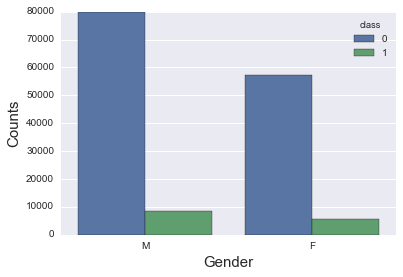

In [17]:
sns.countplot(x='sex', hue='class', data=fraud_df)
plt.xlabel("Gender", fontsize=15)
plt.ylabel("Counts", fontsize=15)

Next, I explore the relationship between purchase value and fraud. Although there is a slight increase in the average purchase value associated with fraudulent activity, the errors bars are far too high to spot a real trend.

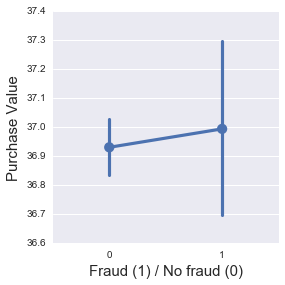

In [18]:
sns.factorplot(x="class", y="purchase_value", data=fraud_df)
plt.xlabel("Fraud (1) / No fraud (0)", fontsize=15)
plt.ylabel("Purchase Value", fontsize=15)

Next, I explore the relationship between age and fraud. At first glance, it looks like there may be a useful trend here but the ages are actually very close together and are essentially both right on top of the average and median user age. Again, this is not likely to be terribly useful.

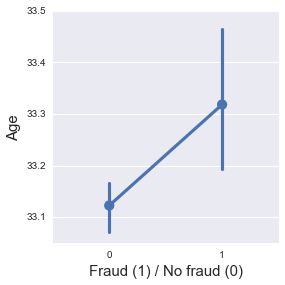

In [19]:
sns.factorplot(x="class", y="age", data=fraud_df)
plt.xlabel("Fraud (1) / No fraud (0)", fontsize=15)
plt.ylabel("Age", fontsize=15)

Next, I explore the relationship between marketing source and fraud. It doesn't look like any given marketing source is more associated with fraud either. Although there are less direct sources associated with fraud, there are less direct sources overall and so the decrease likely has more to do with just not being as successful as search engine optimization and ads in bringing customers to the site.

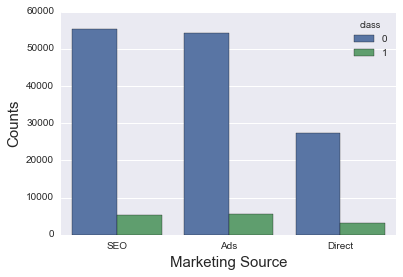

In [20]:
sns.countplot(x='source', hue='class', data=fraud_df)
plt.xlabel("Marketing Source", fontsize=15)
plt.ylabel("Counts", fontsize=15)

Next, I explore the relationship between browser used and fraud. Again, the browser counts seem to be more indicative of their relative overall popularity rather than any meaningful trend associated with fraud.

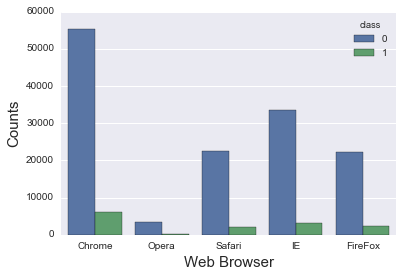

In [21]:
sns.countplot(x='browser', hue='class', data=fraud_df)
plt.xlabel("Web Browser", fontsize=15)
plt.ylabel("Counts", fontsize=15)

Next, I explore the relationship between country of origin and fraud. It's impossible to represent 250+ countries in a visually nice way so I'll resort, in this case, to doing it in an ugly way. Below, I display a pie chart showing the share of anomalous instances each country is responsible for. For the most part, the chart seems to represent more the relative share of total world-wide active internet users in each country and not necessarily those associated with fraud. For instance, I certainly wouldn't flag every US-based user as a potential fraudster. 

However, the "Missing" designation does seem to also occupy quite a lot of the pie chart. Because of this, it may be useful to further examine the effect of country of origin using feature selection.

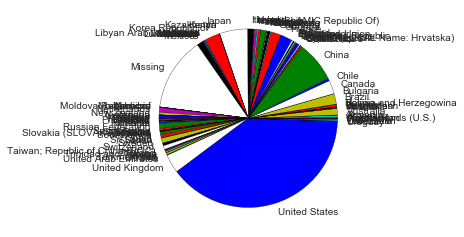

In [22]:
sums = fraud_df[fraud_df["class"] == 1]["class"].groupby(fraud_df.country).sum()
plt.axis('equal')
plt.pie(sums, labels=sums.index)
plt.show()

Next, I explore the relationship between the number of unique user ids assocated with either a single device or a single ip address. These are clearly important correlations. It seems that multiple user ids associated with either a unique device id or ip address is a large indicator of fraudulent behaviour.

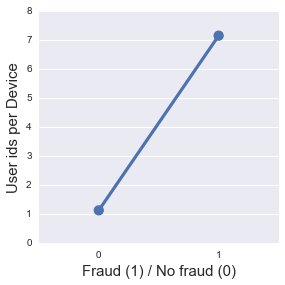

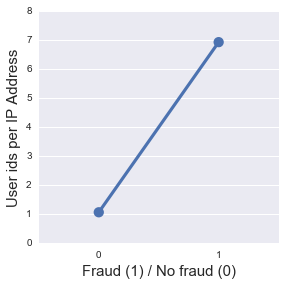

In [23]:
# Initialize a new dataframe
tmp_df = pd.DataFrame(columns=("class", "userids_per_deviceid", "userids_per_ipaddress"))
tmp_df["class"] = fraud_df["class"]

# Count the number of unique user ids associated each device
userid_count = fraud_df.groupby("device_id").user_id.count()
tmp_df["userids_per_deviceid"] = fraud_df.device_id.apply(lambda x: userid_count[x])

# Count the number of unique user ids associated each ip address
userid_count = fraud_df.groupby("ip_address").user_id.count()
tmp_df["userids_per_ipaddress"] = fraud_df.ip_address.apply(lambda x: userid_count[x])

sns.factorplot(x="class", y="userids_per_deviceid", data=tmp_df)
plt.xlabel("Fraud (1) / No fraud (0)", fontsize=15)
plt.ylabel("User ids per Device", fontsize=15)

sns.factorplot(x="class", y="userids_per_ipaddress", data=tmp_df)
plt.xlabel("Fraud (1) / No fraud (0)", fontsize=15)
plt.ylabel("User ids per IP Address", fontsize=15)

Finally, I explore the relationship between the time between sign-up and purchase and fraud. These are also very clearly important correlations. Extremely small time periods between sign-up and purchase are also strongly correlated with fraud.

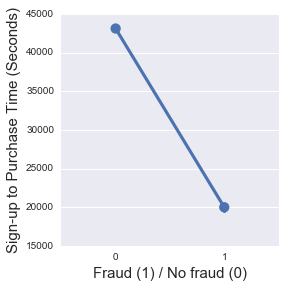

In [24]:
# Convert sign-up time and purchase time to datetime objects
tmp_df["signup_time"] = fraud_df.signup_time.apply(pd.to_datetime)
tmp_df["purchase_time"] = fraud_df.purchase_time.apply(pd.to_datetime)

# Add columns for the number of seconds between purchase and sign-up times
tmp_df["signup_to_purchase_seconds"] = (tmp_df.purchase_time - tmp_df.signup_time).apply(lambda x: x.seconds)

sns.factorplot(x="class", y="signup_to_purchase_seconds", data=tmp_df)
plt.xlabel("Fraud (1) / No fraud (0)", fontsize=15)
plt.ylabel("Sign-up to Purchase Time (Seconds)", fontsize=15)

Next, I explore the relationship between time (hour of the day, day of the week, week of the year) and fraud. It looks like fraud occurs pretty regularly throughout the hours of the day and days of the week. However, it looks like a big burst of fraud occurs within the first three weeks of the year. 

I'm not sure why this is. However, I'm not sure it would be a useful feature to have in the dataset as many normal customers also visit the site during that period. I think it's more appropriate to simply strongly recommend that the company security team is on high alert for fraud during the first three weeks of the year.

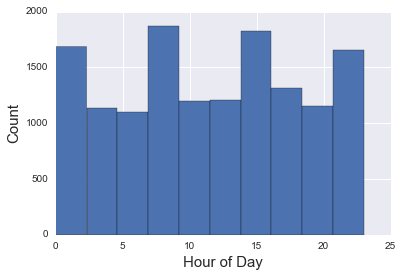

In [25]:
tmp_df[tmp_df["class"] == 1].signup_time.apply(lambda x: x.hour).hist()
plt.xlabel("Hour of Day", fontsize=15)
plt.ylabel("Count", fontsize=15)

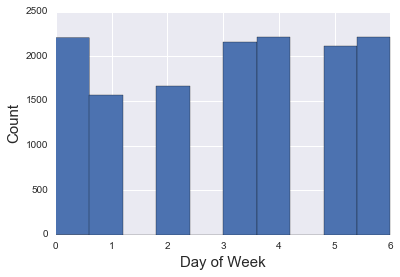

In [26]:
tmp_df[tmp_df["class"] == 1].signup_time.apply(lambda x: x.dayofweek).hist()
plt.xlabel("Day of Week", fontsize=15)
plt.ylabel("Count", fontsize=15)

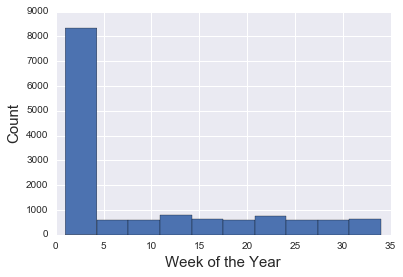

In [27]:
tmp_df[tmp_df["class"] == 1].signup_time.apply(lambda x: x.week).hist()
plt.xlabel("Week of the Year", fontsize=15)
plt.ylabel("Count", fontsize=15)

In the next section, I construct the features based on country of origin, number of user ids associated with unique device ids and ip addresses, and time periods between sign-up and purchase.

## Feature engineering   
Here, I'll list all the new features that I'll add in this section.
* Multiple user ids for a unique device or ip address
    * Both are equally good indicators. 
    * They're highly correlated. In order to avoid any multi-colinearity, I'll generate only one feature which will be the average of the number of user ids associated with either the device id or the ip address.
* Time between sign-up and first purchase in seconds
* One-hot-encoded features for each country

In [28]:
# First reload the dataset
fraud_df = pd.read_csv("Fraud_Data/Fraud_Data_with_Countries.csv", header=0)

# Add column corresponding to the number of unique user id's associated with the given device id
userid_count = fraud_df.groupby("device_id").user_id.count()
fraud_df["userids_per_deviceid"] = fraud_df.device_id.apply(lambda x: userid_count[x])

# Add column corresponding to the number of unique user id's associated with the given ip address
userid_count = fraud_df.groupby("ip_address").user_id.count()
fraud_df["userids_per_ipaddress"] = fraud_df.ip_address.apply(lambda x: userid_count[x])

# Add column for the average of the previous two columns
fraud_df["mean_number_of_userids"] = (fraud_df.userids_per_deviceid + fraud_df.userids_per_ipaddress) * 0.5

# Convert sign-up time and purchase time to datetime objects
fraud_df.signup_time = fraud_df.signup_time.apply(pd.to_datetime)
fraud_df.purchase_time = fraud_df.purchase_time.apply(pd.to_datetime)

# Add columns for the number of seconds and days between purchase and sign-up times
fraud_df["signup_to_purchase_seconds"] = (fraud_df.purchase_time - fraud_df.signup_time).apply(lambda x: x.seconds)

# Create dummy columns for country feature
country_dummies = pd.get_dummies(fraud_df.country, prefix='country')
fraud_df = pd.concat([fraud_df, country_dummies], axis=1)

# Drop spurious columns
fraud_df.drop(["user_id", 
               "signup_time", 
               "purchase_time", 
               "device_id", 
               "ip_address", 
               "userids_per_deviceid",
               "userids_per_ipaddress",
               "country",
               "source",
               "browser",
               "sex",
               "age",
               "purchase_value"
               ], axis=1, inplace=True)

At this point, I have 150+ features. In order to reduce this, I'll do feature selection but it's important to do feature selection on the actual features you'll be using. Since the anomaly detection algorithms I'll be using later benefit from having features that are more gaussian than not, I'll first transform the non-categorical features.   

The first feature is the mean number of user ids. It is bi-modal, with a big spike around 1-1.5 and then a gaussian distribution centered around 12 with a standard deviation of roughly 3. Due to the bi-modal nature, there's nothing more I can do about making this more gaussian so I'll just keep it the way it is.

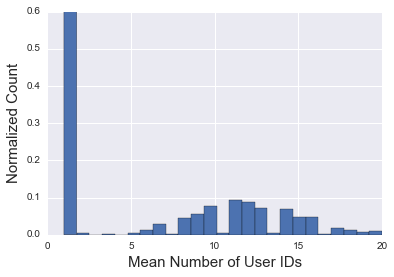

In [29]:
fraud_df[fraud_df["class"]==1].mean_number_of_userids.hist(normed=True, bins=25)
plt.xlabel("Mean Number of User IDs", fontsize=15)
plt.ylabel("Normalized Count", fontsize=15)

The signup_to_purchase_seconds feature is rather uniformly distributed.

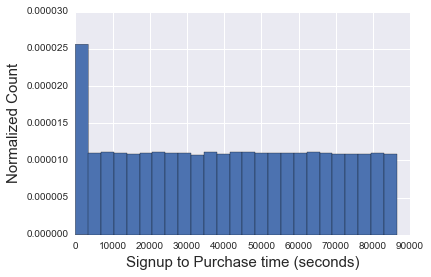

In [30]:
fraud_df.signup_to_purchase_seconds.hist(normed=True, bins=25)
plt.xlabel("Signup to Purchase time (seconds)", fontsize=15)
plt.ylabel("Normalized Count", fontsize=15)

In this case, we can use the following transformation
$$ X = \sqrt{2} \; \text{erf}^{-1} \left( 2 \Phi - 1 \right) $$
where $\Phi$ is a uniformly distributed random variable, $X$ is a normally distributed random variable, and $\text{erf}^{-1}$ is the inverse of the error function. However, before this transformation can be done I need to first normalize the feature to lie between 0 and 1.

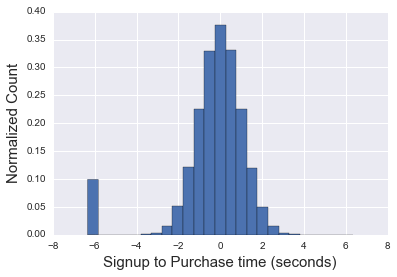

In [31]:
def rescale_series(ser):
    ser_min = ser.min() - 1e-5
    ser_max = ser.max() + 1e-5
    new_ser = (ser - ser_min) / (ser_max - ser_min)
    new_ser = new_ser.apply(lambda x: np.sqrt(2) * special.erfinv(2 * x - 1))
    return new_ser

fraud_df["signup_to_purchase_time"] = rescale_series(fraud_df.signup_to_purchase_seconds)
fraud_df.drop("signup_to_purchase_seconds", axis=1, inplace=True)
fraud_df.signup_to_purchase_time.hist(normed=True, bins=25)
plt.xlabel("Signup to Purchase time (seconds)", fontsize=15)
plt.ylabel("Normalized Count", fontsize=15)

All desired features are now created but I'll now rescale them to lie between 0 and 1.

In [32]:
def rescale_series(ser):
    ser_min = ser.min()
    ser_max = ser.max()
    new_ser = (ser - ser_min) / (ser_max - ser_min)
    return new_ser

# Get all column names that are not one-hot-encoded
non_onehotencoded_cols = [feature for feature in fraud_df.columns if "country" not in feature and feature != "class"]

# Rescale all non one-hot-encoded columns
for col in non_onehotencoded_cols:
    fraud_df[col] = rescale_series(fraud_df[col])

X = fraud_df[ [col for col in fraud_df.columns if col != "class"] ]
Y = fraud_df["class"]

At the moment, I have over almost 200 features which is a bit much. I'll perform feature selection here with an extra trees classifier to reduce this number.

In [33]:
# Create an instance of the extra trees classifier
clf = ExtraTreesClassifier(n_estimators=200)
_ = clf.fit(X, Y)

# Create a dataframe to map features to their importances
features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = clf.feature_importances_

# Print out important features
features[ features.importance > np.mean(features.importance) ].sort_values(by='importance', ascending=False)

,feature,importance
183,signup_to_purchase_time,0.677502
0,mean_number_of_userids,0.316941


It looks like the country of origin doesn't matter after all. Since there are only two features, I can visualize the data quite easily.

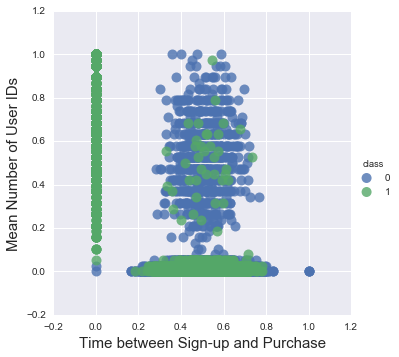

In [34]:
X = fraud_df[ [col for col in fraud_df.columns if "country" not in col and col != "class"] ]

sns.lmplot("signup_to_purchase_time", "mean_number_of_userids",
           data=pd.concat([X, Y], axis=1),
           fit_reg=False,
           hue="class",  
           scatter_kws={"marker": "D", "s": 100})
plt.xlabel('Time between Sign-up and Purchase', fontsize=15)
plt.ylabel('Mean Number of User IDs', fontsize=15)

The fraud and non-fraud points are not completely isolated from each other so it's not clear what kind of performance I should expect. We'll see in the next section how the models perform. Before moving on, I'll just re-index the data for cleanliness.

In [35]:
X.index = range(len(X))
Y.index = range(len(Y))

## Modeling
There are two ways to approach anomaly detection from a modeling perspective, supervised and unsupervised. I'll begin with the supervised approach where I employ an isolation forest algorithm. 

The isolation forest isolates observations by randomly selecting a feature and then recursively selecting random split values until the sample is isolated. This recursive splitting can be represented as a tree structure where the number of splittings is equivalent to the path length from the root node to the terminating node. This path length, averaged over a forest of similarly generated trees, is measure of normality. The shorter the average path length, the less work it takes to isolate the sample and the more likely it is that the sample represents an anomaly.   

Below, I perform a 5-fold cross validation with a grid search over the number of estimators in the forest. As I'm interested in maximizing both precision and recall simultaneously, I score each cross validation using the F1 score.

In [36]:
# Split the data 
X_dev, X_eval, Y_dev, Y_eval = train_test_split(X, Y, train_size=.75, random_state=23)
# The isolation forest returns values of 1 for normal and -1 for anomalous so I transform target values to match
Y_dev = Y_dev.apply(lambda x: 1 if x == 0 else -1)
Y_eval = Y_eval.apply(lambda x: 1 if x == 0 else -1)

# Initiate the isolation forest class and specify the percentage of anomalous samples in the development dataset
IF = IsolationForest(max_samples="auto", contamination=0.095)

# Define the parameter grid to search over
param_grid = {"n_estimators": [100, 150, 200, 250, 300, 350, 400, 450, 500]}

# Define the grid search object
clf = GridSearchCV(IF, 
                   param_grid=param_grid, 
                   cv=5, 
                   n_jobs=10,
                   scoring="f1",
                   verbose=10)

# Perform grid search
_ = clf.fit(X_dev, Y_dev)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] n_estimators=100 ................................................
[CV] n_estimators=100 ................................................
[CV] n_estimators=100 ................................................
[CV] n_estimators=100 ................................................
[CV] n_estimators=100 ................................................
[CV] n_estimators=150 ................................................
[CV] n_estimators=150 ................................................
[CV] n_estimators=150 ................................................
[CV] n_estimators=150 ................................................
[CV] n_estimators=150 ................................................
[CV] ....................... n_estimators=100, score=0.956335 -  15.7s
[CV] ....................... n_estimators=100, score=0.957250 -  16.0s
[CV] n_estimators=200 ................................................
[CV] ............

[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   16.8s


[CV] ....................... n_estimators=150, score=0.957746 -  22.4s
[CV] ....................... n_estimators=150, score=0.958184 -  22.9s
[CV] n_estimators=250 ................................................
[CV] n_estimators=250 ................................................
[CV] ....................... n_estimators=150, score=0.956602 -  23.3s
[CV] ....................... n_estimators=150, score=0.957254 -  23.4s
[CV] ....................... n_estimators=150, score=0.957082 -  23.6s
[CV] n_estimators=250 ................................................
[CV] n_estimators=250 ................................................
[CV] n_estimators=250 ................................................
[CV] ....................... n_estimators=200, score=0.958191 -  34.3s
[CV] ....................... n_estimators=200, score=0.958199 -  34.6s
[CV] n_estimators=300 ................................................
[CV] n_estimators=300 ................................................


[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   51.0s


[CV] ....................... n_estimators=200, score=0.958447 -  34.5s
[CV] ....................... n_estimators=200, score=0.956583 -  35.0s
[CV] n_estimators=300 ................................................
[CV] n_estimators=300 ................................................
[CV] ....................... n_estimators=200, score=0.956475 -  35.5s
[CV] n_estimators=300 ................................................
[CV] ....................... n_estimators=250, score=0.958490 -  45.1s
[CV] n_estimators=350 ................................................
[CV] ....................... n_estimators=250, score=0.958240 -  45.5s
[CV] ....................... n_estimators=250, score=0.958521 -  44.8s
[CV] n_estimators=350 ................................................
[CV] n_estimators=350 ................................................
[CV] ....................... n_estimators=250, score=0.956271 -  45.5s
[CV] n_estimators=350 ................................................
[CV] .

[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  1.8min


[CV] ....................... n_estimators=300, score=0.958243 -  54.6s
[CV] n_estimators=400 ................................................
[CV] ....................... n_estimators=300, score=0.956441 -  54.2s
[CV] ....................... n_estimators=300, score=0.958332 -  53.6s
[CV] n_estimators=400 ................................................
[CV] n_estimators=400 ................................................
[CV] ....................... n_estimators=300, score=0.957258 -  54.8s
[CV] n_estimators=400 ................................................
[CV] ....................... n_estimators=350, score=0.957966 - 1.0min
[CV] ....................... n_estimators=350, score=0.958275 - 1.0min
[CV] n_estimators=450 ................................................
[CV] ....................... n_estimators=350, score=0.956657 - 1.0min
[CV] ....................... n_estimators=350, score=0.958303 - 1.0min
[CV] n_estimators=450 ................................................
[CV] n

[Parallel(n_jobs=10)]: Done  31 out of  45 | elapsed:  2.9min remaining:  1.3min


[CV] n_estimators=500 ................................................
[CV] ....................... n_estimators=400, score=0.956752 - 1.2min
[CV] ....................... n_estimators=400, score=0.958070 - 1.2min
[CV] ....................... n_estimators=400, score=0.956373 - 1.2min
[CV] n_estimators=500 ................................................
[CV] n_estimators=500 ................................................
[CV] n_estimators=500 ................................................
[CV] ....................... n_estimators=450, score=0.957569 - 1.4min


[Parallel(n_jobs=10)]: Done  36 out of  45 | elapsed:  3.5min remaining:   53.2s


[CV] ....................... n_estimators=450, score=0.957457 - 1.4min
[CV] ....................... n_estimators=450, score=0.958597 - 1.4min
[CV] ....................... n_estimators=450, score=0.958222 - 1.4min
[CV] ....................... n_estimators=450, score=0.956744 - 1.4min
[CV] ....................... n_estimators=500, score=0.958759 - 1.1min


[Parallel(n_jobs=10)]: Done  41 out of  45 | elapsed:  4.0min remaining:   23.4s


[CV] ....................... n_estimators=500, score=0.958247 - 1.1min
[CV] ....................... n_estimators=500, score=0.957598 - 1.1min
[CV] ....................... n_estimators=500, score=0.958416 - 1.1min
[CV] ....................... n_estimators=500, score=0.956967 - 1.1min


[Parallel(n_jobs=10)]: Done  45 out of  45 | elapsed:  4.0min finished


Here I print out the full classification report and produce the ROC curve.

             precision    recall  f1-score   support

  anomalous       0.60      0.59      0.59      3546
     normal       0.96      0.96      0.96     34232

avg / total       0.92      0.92      0.92     37778

Area under ROC curve: 0.773


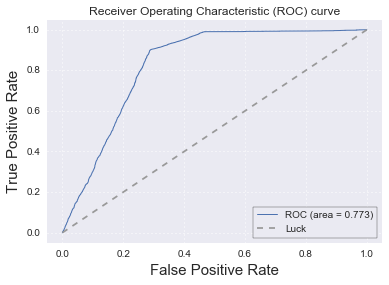

In [37]:
IF_best = clf.best_estimator_
Y_predicted = IF_best.predict(X_eval)
roc_auc = roc_auc_score(Y_eval, Y_predicted)

print classification_report(Y_eval, 
                            Y_predicted,
                            target_names=["anomalous", "normal"])
print "Area under ROC curve: {:0.3f}".format(roc_auc)

# Compute ROC curve and area under the curve
IF_probs = IF_best.decision_function(X_eval)
fpr, tpr, thresholds = roc_curve(Y_eval, IF_probs)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.3f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) curve', fontsize=12)
plt.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')
plt.grid(True, linestyle = 'dotted')
plt.show()

I'll also plot the decision boundary here.

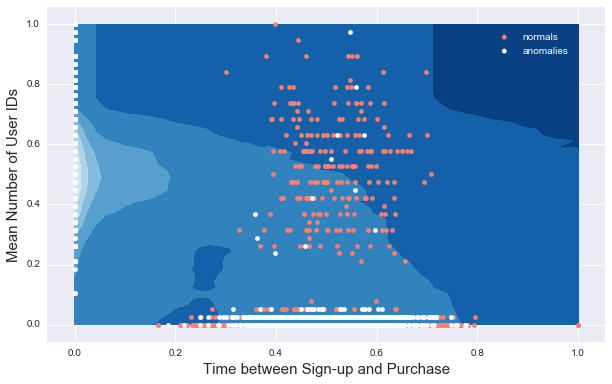

In [38]:
# Set figure size
plt.figure(figsize=(10,6))

# plot the contour lines
xx, yy = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
Z = IF_best.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

# Plot normal and anomalous data
plt.scatter(X_eval[Y_eval==1].signup_to_purchase_time, X_eval[Y_eval==1].mean_number_of_userids, 
            color="salmon", label="normals")
plt.scatter(X_eval[Y_eval==-1].signup_to_purchase_time, X_eval[Y_eval==-1].mean_number_of_userids, 
            color="white", label="anomalies")

# Set labels and legend
plt.xlabel('Time between Sign-up and Purchase', fontsize=15)
plt.ylabel('Mean Number of User IDs', fontsize=15)
for text in plt.legend(bbox_to_anchor=(.95, .95)).get_texts():
    text.set_color("white")

Now I'll try the unsupervised approach. In this approach, an algorithm is fed only normal data, i.e., with no anomalies in it. From this, it learns a decision boundary surrounding the normal data and then classifies new data as similar or different to the training set. 

Because this algorithm is unsupervised, splitting the dataset is somewhat non-standard. All the anomalies should be in the cross validation and evaluation sets only. The model will learn a decision boundary surrounding the normal data and then try to identify anomalies by their N-dimensional distance from the inside of this boundary. The cross validation and evaluation sets will consist of a mix of normal and anomalous instances. It doesn't seem that scikit-learn provides this kind of split so I'll do it here by hand.

In [42]:
# Add the target vector back to the feature set
X["class"] = Y

# Separate the anomalies from the normals
X_anomalies = X[ X["class"] == 1 ]
X_normals = X[ X["class"] == 0 ]

# Randomly sample 70% of the indices of the normal dataset for training
train_idxs = sample(X_normals.index, int(0.7 * X_normals.shape[0]))
X_train = X_normals.ix[train_idxs]
# Keep the rest for the testing set
X_testing = X_normals.drop(train_idxs)
# The testing set should now be the combination of the remaining normal instances not in the training set
# and the anomaly instances
X_testing = pd.concat([X_testing, X_anomalies], axis=0)

# Shuffle the rows for both datasets
X_train = X_train.sample(frac=1).reset_index(drop=True)
X_testing = X_testing.sample(frac=1).reset_index(drop=True)

# Split the testing dataframe up into cross validation and evaluation datasets
Y_testing = X_testing["class"]
X_testing = X_testing[ [col for col in X_testing.columns if col != "class"] ]
X_cv, X_eval, Y_cv, Y_eval = train_test_split(X_testing, Y_testing, train_size=.7, random_state=23)

# Map Y_cv and Y_eval values to 1 (normal), -1 (anomalies) convention
Y_cv = Y_cv.apply(lambda x: 1 if x == 0 else -1)
Y_eval = Y_eval.apply(lambda x: 1 if x == 0 else -1)

# Finally, drop the class column from the training set
X_train = X_train[ [col for col in X_testing.columns if col != "class"] ]

I now fit the hyperparameters using cross validation. First, I choose a random set of hyperparameters. Using this set, I then fit the one class SVM model to the training data and use this fitted model to predict the cross validation set target vector values. I then use the F1 score to simultaneously optimize the precision and recall while comparing my predictions with the ground truth values.

In [43]:
# Define the parameter grid to search over
param_grid = {"nu": np.linspace(0.001, .01, 5), "gamma": [0.01, .03, 0.1, 0.3]}
param_list = list(itertools.product(param_grid["nu"], param_grid["gamma"]))

def random_gridsearch(param_list, n_sample, X_train, X_cv, Y_cv):

    f1_max = 0
    param_list = sample(param_list, n_sample)
    remaining_fits = n_sample
    print "Performing {} fits...\n".format(remaining_fits)
    for params in param_list:
        # Initialize class and set hyperparameters
        nu, gamma = params
        OCSVM = OneClassSVM(kernel="rbf", nu=nu, gamma=gamma)

        # Fit model
        print "Fitting model..."
        OCSVM.fit(X_train)

        # Calculate F1 score
        cv_preds = OCSVM.predict(X_cv)
        f1 = f1_score(Y_cv.values, cv_preds, average="binary")

        # Print results
        print "F1 score based on nu={0:.3f}, gamma={1:.2f}: {2:.3f}".format(nu, gamma, f1)

        # Optimize for F1 score
        if f1 > f1_max:
            f1_max = f1
            OCSVM_best = OCSVM

        remaining_fits -= 1
        print "{} fits remaining...".format(remaining_fits)
        
    return f1_max, OCSVM_best
        
f1_max, OCSVM_best = random_gridsearch(param_list, 10, X_train, X_cv, Y_cv)

Performing 10 fits...

Fitting model...
F1 score based on nu=0.010, gamma=0.30: 0.923
9 fits remaining...
Fitting model...
F1 score based on nu=0.001, gamma=0.10: 0.926
8 fits remaining...
Fitting model...
F1 score based on nu=0.008, gamma=0.03: 0.924
7 fits remaining...
Fitting model...
F1 score based on nu=0.001, gamma=0.30: 0.926
6 fits remaining...
Fitting model...
F1 score based on nu=0.003, gamma=0.10: 0.926
5 fits remaining...
Fitting model...
F1 score based on nu=0.001, gamma=0.03: 0.926
4 fits remaining...
Fitting model...
F1 score based on nu=0.010, gamma=0.03: 0.923
3 fits remaining...
Fitting model...
F1 score based on nu=0.006, gamma=0.10: 0.925
2 fits remaining...
Fitting model...
F1 score based on nu=0.003, gamma=0.01: 0.926
1 fits remaining...
Fitting model...
F1 score based on nu=0.008, gamma=0.01: 0.924
0 fits remaining...


Here I print out the full classification report and produce the ROC curve.

             precision    recall  f1-score   support

  anomalous       1.00      0.53      0.69      4287
     normal       0.86      1.00      0.92     12285

avg / total       0.89      0.88      0.86     16572

Area under ROC curve: 0.765


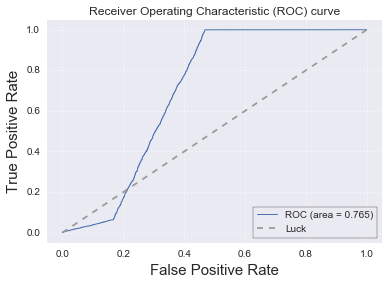

In [44]:
OCSVM_best.fit(X_train)
Y_predicted = OCSVM_best.predict(X_eval)
roc_auc = roc_auc_score(Y_eval, Y_predicted)

print classification_report(Y_eval, 
                            Y_predicted,
                            target_names=["anomalous", "normal"])
print "Area under ROC curve: {:0.3f}".format(roc_auc)

# Compute ROC curve and area under the curve
OCSVM_probs = OCSVM_best.decision_function(X_eval)
fpr, tpr, thresholds = roc_curve(Y_eval, OCSVM_probs)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.3f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) curve', fontsize=12)
plt.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')
plt.grid(True, linestyle = 'dotted')
plt.show()

I'll also plot the decision boundary here.

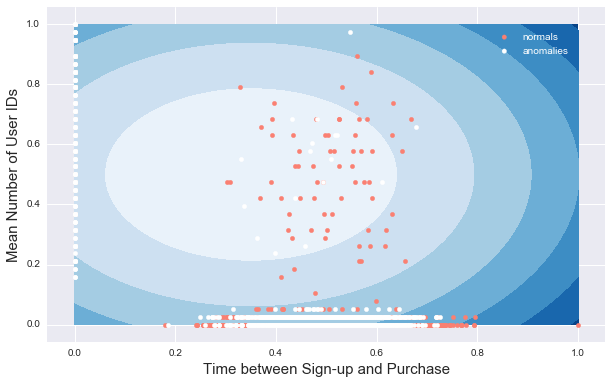

In [45]:
# Set figure size
plt.figure(figsize=(10,6))

# plot the contour lines
xx, yy = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
Z = OCSVM_best.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

# Plot normal and anomalous data
plt.scatter(X_eval[Y_eval==1].signup_to_purchase_time, X_eval[Y_eval==1].mean_number_of_userids, 
            color="salmon", label="normals")
plt.scatter(X_eval[Y_eval==-1].signup_to_purchase_time, X_eval[Y_eval==-1].mean_number_of_userids, 
            color="white", label="anomalies")

# Set labels and legend
plt.xlabel('Time between Sign-up and Purchase', fontsize=15)
plt.ylabel('Mean Number of User IDs', fontsize=15)
for text in plt.legend(bbox_to_anchor=(.95, .95)).get_texts():
    text.set_color("white")

## Conclusions

**Observations**:
* Not all ip addresses in the dataset can be tracked to a country of origin. Regardless, it seems as though country of origin does not play a significant role in identifying fraud so it doesn't really matter.
* I built two models:
    * Isolation forest: a supervised alogorithm based on analyzing how many splits on features are necessary to isolate a given sample.
    * One Class Support Vector Machine: an unsupervised algorithm based on learning a decision boundary surrounding non-anomalous data and then trying to identify anomalies by determining their distance from this boundary.     
* To optimize for both precision and recall simultaneously, I decided to optimize for F1 score rather than accuracy. Using this method of optimization, I found that **the isolation forest performs better than the one class SVM**. The SVM has a very high precision for identifying fraud but a rather low recall for fraud. This indicates to me that the SVM is simply guessing fraud more often than the isolation forest. This understanding is supported by plots of the decision boundaries. The SVM generates a circular decision boundary due to the radial basis function kernel but this doesn't allow for much flexibility in the face of a multi-modal, non-gaussian feature space. The isolation forest is far more flexible and so, even though its scores are not drastically different, I expect it to generalize much better than the SVM to further data. 
* The most important features, in order of importance, to spot fraud were determined to be:
    * The speed at which they moved through the entire sales funnel (from sign-up to purchase)
    * Whether or not multiple user id's were being generated from a single device or ip address

**Recommendations**:   
I recommend implementing the isolation forest model into production. I also have two specific recommendations for the user experience team and one for the security team.
1. Make sure to require the full name and email address from a user in order to sign up. When a user forgets their username/password, give them an easy path to follow to **reset** their password and require their full name and email address in order to do it. That way, the user's original user id can be found in the database and deleted before giving them a new user id. This minimizes the chances of a normal user having multiple user id's and reduces the chances of mistaking them for a fraudster.
2. After a user signs up, immediately present them with potential offers/discounts if possible. This could be advertised as a simple thank you for signing up but, for normal users, it will increase their chances of moving to purchase while also giving them something to consider and thereby slowing them down a little bit, making it harder to confuse them with a bot which would likely ignore all offers for discounts.
3. I also strongly recommend enhancing security during the first three weeks of the year as there seems to be a spike in fraudulent activity during that time.